In [2]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
from enum import Enum

In [17]:
class Datasets(Enum):
    PPI = 1
    KKI = 2
    CORA = 3
    
DATASET_TO_USED = Datasets.CORA

def get_ppi_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

def get_kki_dataset(emb_file):
    """
    returns a dataframe with embeddings and labels
    """
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    labels = [[int(line)] for line in open(LABELS_FILE).read().splitlines()]
    node_ids = [x for x in range(1, len(labels)+1)]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

# TODO: REMOVE IT IF IT'S NOT USED LATER, it was used for blogcatalog dataset. 
# Could be used for other datasets as well if they have same format
def get_cora_dataset(emb_file):
    # first row has the # of nodes and features
    emb_df = pd.read_csv(emb_file, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(LABELS_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df

if DATASET_TO_USED == Datasets.CORA:
    LABELS_FILE = "../data/cora/cora.node_labels"
    emb_file = "../emb/cora.emb"
    INPUT_FILE = "../data/cora/cora.edges"
    df = get_cora_dataset(emb_file)
elif DATASET_TO_USED == Datasets.PPI:
    LABELS_FILE = "../data/PPI/ppi_labels.txt"
    emb_file = "../emb/ppi.emb"
    INPUT_FILE = "../data/PPI/ppi.edgelist"
    df = get_ppi_dataset(emb_file)
elif DATASET_TO_USED == Datasets.KKI:
    LABELS_FILE = "../data/KKI/KKI.node_labels"
    emb_file = "../emb/kki.emb"
    INPUT_FILE = "../data/KKI/KKI.edges"
    df = get_kki_dataset(emb_file)
    
df.head()

,node_id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f120,f121,f122,f123,f124,f125,f126,f127,f128,labels
0,164,0.124418,-0.047874,-0.470207,0.248424,0.070112,-0.025420,-0.435457,0.265799,-0.120067,...,0.264454,-0.193090,-0.217971,0.096957,0.055578,-0.001460,0.204529,0.194625,-0.070133,[2]
1,566,-0.282247,0.263943,-0.094395,-0.152476,-0.023648,-0.260539,-0.462344,0.099615,-0.220497,...,0.220532,-0.062750,0.061593,0.276616,0.038674,0.049655,-0.280821,0.219660,0.168847,[5]
2,748,-0.438979,0.309077,-0.364761,-0.256777,-0.115516,0.019527,-0.436590,0.034774,-0.202118,...,0.471562,0.161027,-0.540524,-0.173738,-0.032109,-0.031306,0.142167,0.160664,0.255580,[3]
3,428,-0.134146,0.159597,0.055691,-0.008273,-0.128141,0.054291,-0.352044,0.283726,-0.156044,...,0.288102,-0.171833,-0.304977,-0.534091,0.246362,0.012199,0.415772,-0.179337,-0.070166,[3]
4,612,-0.074499,-0.015492,0.117418,-0.171635,0.335825,-0.204142,-0.152158,0.270461,0.257844,...,0.053563,-0.066204,0.094065,-0.400403,0.138271,0.085988,0.097177,0.079217,0.152595,[3]


In [4]:
# Extend prediction function for the OVR logistic regression model
# This code is taken from https://github.com/Kombustor/submission-ecir2020-randomwalks/blob/submission/impl/model/classify.py#L11
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

In [11]:
def evaluate(df, test_sizes, num_iter=10):
    evaluations_micro = []
    evaluations_macro = []

    Y = df['labels']
    X = df.drop(columns=['labels', 'node_id'])

    # binarize data
    binarizer = MultiLabelBinarizer()
    binarizer.fit(Y)

    # Linear regression uses L2 regularization by default
    ovr_lr =  OneVsRestClassifier(lr(solver='liblinear'))
    clf = TopKRanker(ovr_lr)

    for test_size in test_sizes:
        micro_scores = []
        macro_scores = []
        for x in range(num_iter):

            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

            Y_train = binarizer.transform(Y_train)

            top_k_list = [len(l) for l in Y_test]
            Y_test = binarizer.transform(Y_test)

            # evaluation
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test, top_k_list=top_k_list)

            micro_scores.append(f1_score(Y_test, Y_pred, average='micro', zero_division=0))
            macro_scores.append(f1_score(Y_test, Y_pred, average='macro', zero_division=0))
        
        evaluations_micro.append(sum(micro_scores)/num_iter*100)
        evaluations_macro.append(sum(macro_scores)/num_iter*100)
        print(f"Perc: {test_size}")
    return evaluations_micro, evaluations_macro

def plot_scores(micro, macro, test_size):
    fig, ax = plt.subplots(figsize=(12, 6))

    micro.reverse()
    macro.reverse()
    
    plt.plot(test_size, micro, marker='o', label='Micro F$_1$')
    plt.plot(test_size, macro, marker='o', label='Macro F$_1$')
        
    plt.xlabel("Test perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.savefig(f"../images/classification/test_sizes_{DATASET_TO_USED}.png", dpi=300)

Perc: 0.1
Perc: 0.2
Perc: 0.3
Perc: 0.4
Perc: 0.5
Perc: 0.6
Perc: 0.7
Perc: 0.8


/home/yasser/.local/share/virtualenvs/node2vec-DO2ocGR2/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(
/home/yasser/.local/share/virtualenvs/node2vec-DO2ocGR2/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(


Perc: 0.9


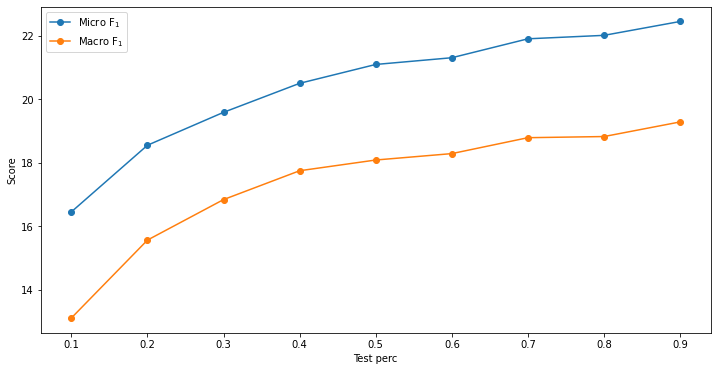

In [14]:
test_size_exp =  [x/10 for x in range(1, 10)]
micro, macro = evaluate(df, test_size_exp, 10)
plot_scores(micro, macro, test_size_exp)

# Grid search for q and p

In [ ]:
import subprocess

grid = {
    'q': [0.25, 0.50, 1, 2, 4],
    'p': [0.25, 0.50, 1, 2, 4]
}

evaluations = []

for p in grid['p']:
    for q in grid['q']:
        print(f"p: {p} q: {q}")
        emb_file =  f"../emb/{DATASET_TO_USED}_q_{q}_p_{p}.emb"

        if DATASET_TO_USED == Datasets.PPI:
            cmd = f"python main.py --p {p} --q {q} --input {INPUT_FILE} --output {emb_file} --weighted "
        elif DATASET_TO_USED == Datasets.CORA:
            cmd = f"python main.py --p {p} --q {q} --input {INPUT_FILE} --output {emb_file} --weighted --delimiter ,"

        subprocess.run(cmd, shell=True)
        
        if DATASET_TO_USED == Datasets.PPI:
            df = get_ppi_dataset(emb_file)
            
        micro, macro = evaluate(df, [0.5])
        
        evaluations.append((q, p, micro, macro))

In [127]:
# Max micro and macro scores
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

max_micro_index = micro.index(max(micro))
max_macro_index = macro.index(max(macro))

print(evaluations[max_micro_index])
print(evaluations[max_macro_index])

(4, 4, [81.73559822747416], [80.6272938735078])
(2, 1, [81.52141802067948], [80.99264894957659])


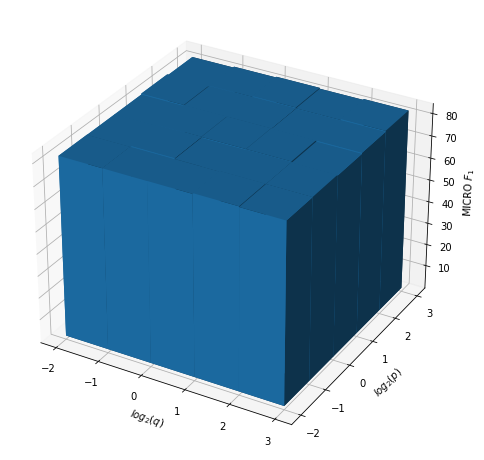

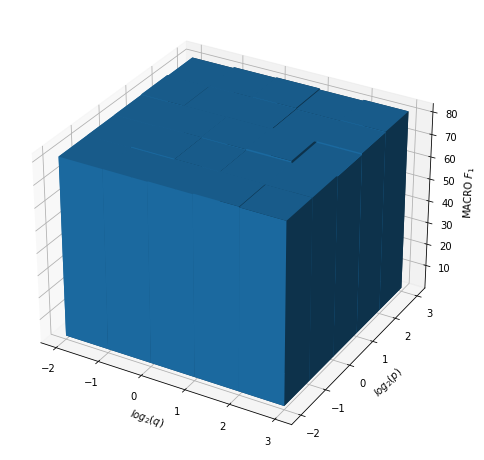

In [130]:
class Scores(Enum):
    MACRO = 1
    MICRO = 2
    
q = [np.log2(x[0]) for x in evaluations]
p = [np.log2(x[1]) for x in evaluations]
micro = [x[2][0] for x in evaluations]
macro = [x[3][0] for x in evaluations]

def plot_grid(p, q, scores, score_enum):
    q = np.array(q)
    p = np.array(p)
    scores = np.array(scores)
    
    if score_enum == Scores.MICRO:
        file_name =  "micro_score"
        label = "MICRO F$_1$"
    elif score_enum == Scores.MACRO:
        file_name =  "macro_score"
        label = "MACRO F$_1$"

    fig = plt.figure(figsize=(8, 16))
    ax = fig.add_subplot(111, projection='3d')

    ax.bar3d(q, p, np.ones(len(scores)),
              1, 1, scores)

    ax.set_xlabel('$\log_2(q)$')
    ax.set_ylabel('$\log_2(p)$')
    ax.set_zlabel(label)
    plt.savefig(f"../images/classification/{file_name}_{DATASET_TO_USED}.png", dpi=300)

plot_grid(p, q, micro, Scores.MICRO)
plot_grid(p, q, macro, Scores.MACRO)